Starting CAFNet training...


Epoch 1/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.24it/s]


Epoch 1/15:
Train Loss: 0.2564, Train AUC: 0.9586
Val Loss: 0.4924, Val AUC: 0.8746
--------------------------------------------------


Epoch 2/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.22it/s]


Epoch 2/15:
Train Loss: 0.1588, Train AUC: 0.9839
Val Loss: 0.4301, Val AUC: 0.9139
--------------------------------------------------


Epoch 3/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]


Epoch 3/15:
Train Loss: 0.1275, Train AUC: 0.9895
Val Loss: 0.4967, Val AUC: 0.9226
--------------------------------------------------


Epoch 4/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.22it/s]


Epoch 4/15:
Train Loss: 0.1113, Train AUC: 0.9919
Val Loss: 0.9595, Val AUC: 0.7108
--------------------------------------------------


Epoch 5/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.26it/s]


Epoch 5/15:
Train Loss: 0.0961, Train AUC: 0.9940
Val Loss: 0.9278, Val AUC: 0.7853
--------------------------------------------------


Epoch 6/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.22it/s]


Epoch 6/15:
Train Loss: 0.0807, Train AUC: 0.9957
Val Loss: 0.8830, Val AUC: 0.7978
--------------------------------------------------


Epoch 7/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]


Epoch 7/15:
Train Loss: 0.0706, Train AUC: 0.9967
Val Loss: 0.8076, Val AUC: 0.8449
--------------------------------------------------


Epoch 8/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.23it/s]


Epoch 8/15:
Train Loss: 0.0648, Train AUC: 0.9972
Val Loss: 0.5914, Val AUC: 0.8940
--------------------------------------------------


Epoch 9/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.23it/s]


Epoch 9/15:
Train Loss: 0.0540, Train AUC: 0.9980
Val Loss: 0.8720, Val AUC: 0.8204
--------------------------------------------------


Epoch 10/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.23it/s]


Epoch 10/15:
Train Loss: 0.0467, Train AUC: 0.9985
Val Loss: 1.1526, Val AUC: 0.7772
--------------------------------------------------


Epoch 11/15 - Validation: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]


Epoch 11/15:
Train Loss: 0.0385, Train AUC: 0.9990
Val Loss: 1.0827, Val AUC: 0.7817
--------------------------------------------------
Early stopping at epoch 11
Best validation AUC: 0.9226


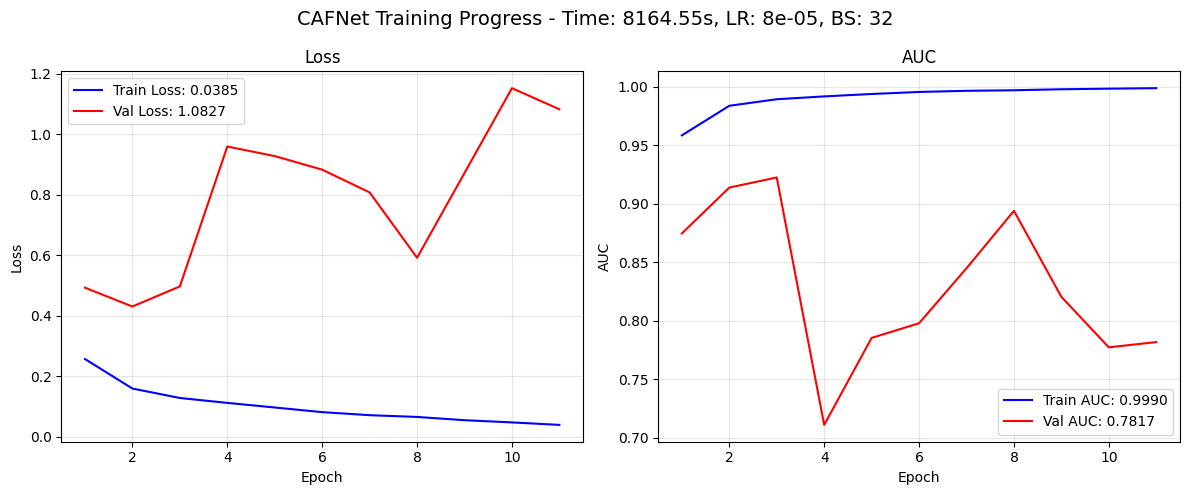

Making predictions on test set...


Making predictions: 100%|██████████| 1845/1845 [04:35<00:00,  6.69it/s]


Submission saved with 59040 predictions
Done! Check submission.csv for results.


In [2]:
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from PIL import Image
import cv2
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import time
warnings.filterwarnings('ignore')

# Configuration
class Config:
    input_dir = "/kaggle/input/multimodal-cancer-classification-challenge-2025"
    BF_TRAIN_PATH = input_dir + '/BF/train'
    BF_TEST_PATH = input_dir + '/BF/test'
    FL_TRAIN_PATH = input_dir + '/FL/train'
    FL_TEST_PATH = input_dir + '/FL/test'
    TRAIN_CSV = input_dir + '/train.csv'
    BATCH_SIZE = 32  
    EPOCHS = 15
    LEARNING_RATE = 8e-5
    WEIGHT_DECAY = 0.1
    WORLD_SIZE = 2  
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# CAFNet Model Implementation
sigmoid = nn.Sigmoid()

class Swish(torch.autograd.Function):
    @staticmethod
    def forward(ctx, i):
        result = i * sigmoid(i)
        ctx.save_for_backward(i)
        return result
    @staticmethod
    def backward(ctx, grad_output):
        i = ctx.saved_variables[0]
        sigmoid_i = sigmoid(i)
        return grad_output * (sigmoid_i * (1 + i * (1 - sigmoid_i)))

class Swish_Module(nn.Module):
    def forward(self, x):
        return Swish.apply(x)

class ResBlock(nn.Module):
    def __init__(self, c1, c2, stride=1):
        super().__init__()
        if c1 == c2:
            self.downsample = nn.Identity()
        else:
            self.downsample = nn.Conv2d(c1, c2, 1, stride, 0)
        
        self.block = nn.Sequential(
            nn.Conv2d(c1, c2, 3, stride, 1),
            nn.BatchNorm2d(c2),
            nn.ReLU(),
            nn.Conv2d(c2, c2, 3, 1, 1),
            nn.BatchNorm2d(c2)
        )
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.block(x) + self.downsample(x)
        return self.relu(x)

class AFBlock(nn.Module):
    def __init__(self, c=64, cp=64, stride=1, first_stage=False):
        super().__init__()
        self.first_stage = first_stage
        self.cr1 = nn.Sequential(
            nn.Conv2d(c, c//2, 1, 1, 0), nn.ReLU(),
            nn.Conv2d(c//2, c//4, 1, 1, 0), nn.ReLU(),
            nn.Conv2d(c//4, 1, 1, 1, 0)
        )
        self.cr2 = nn.Sequential(
            nn.Conv2d(c, c//2, 1, 1, 0), nn.ReLU(),
            nn.Conv2d(c//2, c//4, 1, 1, 0), nn.ReLU(),
            nn.Conv2d(c//4, 1, 1, 1, 0)
        )
       
        if not first_stage:
            self.resblocks = nn.Sequential(
                ResBlock(cp, c, stride=stride), ResBlock(c, c)
            )
            self.cr3 = nn.Sequential(
                nn.Conv2d(c, c//2, 1, 1, 0), nn.ReLU(),
                nn.Conv2d(c//2, c//4, 1, 1, 0), nn.ReLU(),
                nn.Conv2d(c//4, 1, 1, 1, 0)
            )
            self.cr4 = nn.Sequential(
                nn.Conv2d(c, c//2, 1, 1, 0), nn.ReLU(),
                nn.Conv2d(c//2, c//4, 1, 1, 0), nn.ReLU(),
                nn.Conv2d(c//4, 1, 1, 1, 0)
            )
        self.softmax = nn.Softmax(dim=1)
            
    def forward(self, x1, x2, x_fusion=None):
        x1_cr = self.cr1(x1)
        x2_cr = self.cr2(x2)
        x12_cr = torch.cat([x1_cr, x2_cr], dim=1)
        x12_cr = self.softmax(x12_cr)
        x1_cr, x2_cr = torch.chunk(x12_cr, 2, dim=1)

        x3 = x1 * x1_cr + x2 * x2_cr
        if self.first_stage:
            return x3

        x3_cr = self.cr3(x3)
        x_fusion = self.resblocks(x_fusion)
        x4_cr = self.cr4(x_fusion)
        x34_cr = torch.cat([x3_cr, x4_cr], dim=1) 
        x34_cr = self.softmax(x34_cr)
        x3_cr, x4_cr = torch.chunk(x34_cr, 2, dim=1)
        out = x3 * x3_cr + x_fusion * x4_cr
        return out

class CABlock(nn.Module):
    def __init__(self, c=64):
        super().__init__()
        c_reduce = c//8
        self.to_qk1 = nn.Conv2d(c, c_reduce*2, 1, 1, 0)
        self.to_qk2 = nn.Conv2d(c, c_reduce*2, 1, 1, 0)
        self.to_v1 = nn.Conv2d(c, c, 1, 1, 0)
        self.to_v2 = nn.Conv2d(c, c, 1, 1, 0)
        self.softmax = nn.Softmax(dim=-1)

        self.gamma = nn.Parameter(torch.zeros(1))
        self.beta = nn.Parameter(torch.zeros(1))

    def forward(self, x1, x2):
        b, c, h, w = x1.shape
        q1, k1 = torch.chunk(self.to_qk1(x1), 2, dim=1)
        q2, k2 = torch.chunk(self.to_qk2(x2), 2, dim=1)

        q1 = q1.view(b, -1, h*w).permute(0, 2, 1)
        q2 = q2.view(b, -1, h*w).permute(0, 2, 1)
        k1 = k1.view(b, -1, h*w)
        k2 = k2.view(b, -1, h*w)

        v1 = self.to_v1(x1).view(b, -1, h*w)
        v2 = self.to_v2(x2).view(b, -1, h*w)

        attn1 = self.softmax(torch.bmm(q1, k1))
        attn2 = self.softmax(torch.bmm(q2, k2))
        
        x1 = torch.bmm(v1, attn2).view(b, c, h, w) * self.gamma + x1
        x2 = torch.bmm(v2, attn1).view(b, c, h, w) * self.beta + x2
        return x1, x2

class CAFNet(nn.Module):
    def __init__(self, channel=7, pretrained=True, checkpoint_BF=None, checkpoint_FL=None):
        super().__init__()
        self.name = 'cafnet'
        self.dropout = nn.Dropout(0.3)
        c_BF, c_FL = 3, channel-3
        
        if checkpoint_BF is not None:
            print("BF: Using contrastive learning...")
            
            from resnet_simclr import ResNetSimCLR
            model_BF = ResNetSimCLR('resnet50', c_BF)
            model_BF.load_state_dict(checkpoint_BF['state_dict'])
            self.model_BF = model_BF.backbone
        else:
            self.model_BF = torchvision.models.resnet50(pretrained=True)
        
        if checkpoint_FL is not None:
            print("FL: Using contrastive learning...")
            from resnet_simclr import ResNetSimCLR
            model_FL = ResNetSimCLR('resnet50', c_FL)
            model_FL.load_state_dict(checkpoint_FL['state_dict'])
            self.model_FL = model_FL.backbone
        else:
            self.model_FL = torchvision.models.resnet50(pretrained=True)

        # Define models for BF and FL
        self.conv1_BF = nn.Conv2d(c_BF, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1_BF = self.model_BF.bn1
        self.relu_BF = self.model_BF.relu
        self.maxpool_BF = self.model_BF.maxpool
        self.layer1_BF = self.model_BF.layer1
        self.layer2_BF = self.model_BF.layer2
        self.layer3_BF = self.model_BF.layer3
        self.layer4_BF = self.model_BF.layer4
        self.avgpool_BF = self.model_BF.avgpool

        self.conv1_FL = nn.Conv2d(c_FL, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1_FL = self.model_FL.bn1
        self.relu_FL = self.model_FL.relu
        self.maxpool_FL = self.model_FL.maxpool
        self.layer1_FL = self.model_FL.layer1
        self.layer2_FL = self.model_FL.layer2
        self.layer3_FL = self.model_FL.layer3
        self.layer4_FL = self.model_FL.layer4
        self.avgpool_FL = self.model_FL.avgpool
        
        self.cab1 = CABlock(c=64)
        self.fus1 = AFBlock(c=64, cp=64, stride=1, first_stage=True)
        self.cab2 = CABlock(c=256)
        self.fus2 = AFBlock(c=256, cp=64, stride=1, first_stage=True)
        self.cab3 = CABlock(c=512)
        self.fus3 = AFBlock(c=512, cp=256, stride=2)
        self.cab4 = CABlock(c=1024)
        self.fus4 = AFBlock(c=1024, cp=512, stride=2)
        self.avgpool_fusion = nn.AdaptiveAvgPool2d((1, 1))

        self.fusion_mlp = nn.Sequential(
            nn.Linear(1024, 128),
            Swish_Module(),
        )
        self.BF_mlp = nn.Sequential(
            nn.Linear(2048, 128),
            Swish_Module(),
        )
        self.FL_mlp = nn.Sequential(
            nn.Linear(2048, 128),
            Swish_Module(),
        )

        self.fc_BF = nn.Linear(128, 1)
        self.fc_FL = nn.Linear(128, 1)
        self.fc_fusion = nn.Linear(128, 1)
        self.fc_concat = nn.Linear(128*3, 1)

    def forward(self, x):
        x_BF, x_FL = x

        x_BF = self.conv1_BF(x_BF)
        x_BF = self.bn1_BF(x_BF)
        x_BF = self.relu_BF(x_BF)
        x_BF = self.maxpool_BF(x_BF)

        x_FL = self.conv1_FL(x_FL)
        x_FL = self.bn1_FL(x_FL)
        x_FL = self.relu_FL(x_FL)
        x_FL = self.maxpool_FL(x_FL)

        # Stage 1
        m_BF, m_FL = self.cab1(x_BF, x_FL)
        x_fusion = self.fus1(m_BF, m_FL)
        x_BF = self.layer1_BF(x_BF)
        x_FL = self.layer1_FL(x_FL)

        # Stage 2
        m_BF, m_FL = self.cab2(x_BF, x_FL)
        x_fusion = self.fus2(m_BF, m_FL)
        x_BF = self.layer2_BF(m_BF)
        x_FL = self.layer2_FL(m_FL)

        # Stage 3
        m_BF, m_FL = self.cab3(x_BF, x_FL)
        x_fusion = self.fus3(m_BF, m_FL, x_fusion)
        x_BF = self.layer3_BF(m_BF)
        x_FL = self.layer3_FL(m_FL)

        # Stage 4
        m_BF, m_FL = self.cab4(x_BF, x_FL)
        x_fusion = self.fus4(m_BF, m_FL, x_fusion)
        x_BF = self.layer4_BF(m_BF)
        x_FL = self.layer4_FL(m_FL)

        # Global average pooling and feature extraction
        x_BF = self.avgpool_BF(x_BF)
        x_BF = x_BF.view(x_BF.size(0), -1)
        x_FL = self.avgpool_FL(x_FL)
        x_FL = x_FL.view(x_FL.size(0), -1)
        x_fusion = self.avgpool_fusion(x_fusion)
        x_fusion = x_fusion.view(x_fusion.size(0), -1)

        x_BF = self.BF_mlp(x_BF)
        x_BF = self.dropout(x_BF)
        logit_BF = self.fc_BF(x_BF)

        x_FL = self.FL_mlp(x_FL)
        x_FL = self.dropout(x_FL)
        logit_FL = self.fc_FL(x_FL)
          
        x_fusion = self.fusion_mlp(x_fusion)
        x_fusion = self.dropout(x_fusion)
        logit_fusion = self.fc_fusion(x_fusion)

        x_concat = torch.cat([x_BF, x_FL, x_fusion], dim=1)
        x_concat = self.dropout(x_concat)
        logit_final = self.fc_concat(x_concat)

        return logit_final

# Custom transform for RGBA images
class RGBATransform:
    def __init__(self, resize_size=(128, 128)):
        self.resize_size = resize_size
    
    def __call__(self, img):
        # Resize
        img = img.resize(self.resize_size, Image.Resampling.LANCZOS)
        # Convert to tensor
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Convert to tensor and rearrange dimensions
        tensor = torch.from_numpy(img_array).permute(2, 0, 1)  # HWC -> CHW
        return tensor

class RGBTransform:
    def __init__(self, resize_size=(128, 128)):
        self.resize_size = resize_size
    
    def __call__(self, img):
        # Resize
        img = img.resize(self.resize_size, Image.Resampling.LANCZOS)
        # Convert to tensor
        img_array = np.array(img, dtype=np.float32) / 255.0
        # Convert to tensor and rearrange dimensions
        tensor = torch.from_numpy(img_array).permute(2, 0, 1)  # HWC -> CHW
        # Normalize RGB channels
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        tensor = normalize(tensor)
        return tensor

# Dataset class
class CancerDataset(Dataset):
    def __init__(self, df, bf_path, fl_path, transform_bf=None, transform_fl=None, is_test=False):
        self.df = df
        self.bf_path = bf_path
        self.fl_path = fl_path
        self.transform_bf = transform_bf
        self.transform_fl = transform_fl
        self.is_test = is_test
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['Name']
        
        # Load BF image
        bf_img_path = os.path.join(self.bf_path, img_name)
        bf_img = Image.open(bf_img_path).convert('RGB')
        
        # Load FL image
        fl_img_path = os.path.join(self.fl_path, img_name)
        fl_img = Image.open(fl_img_path).convert('RGBA')
        
        if self.transform_bf:
            bf_img = self.transform_bf(bf_img)
        if self.transform_fl:
            fl_img = self.transform_fl(fl_img)
        
        if self.is_test:
            return (bf_img, fl_img), img_name
        else:
            label = torch.tensor(row['Diagnosis'], dtype=torch.float32)
            return (bf_img, fl_img), label

# Data transforms - separate for BF and FL
train_transform_bf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transform_bf = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For FL images (RGBA) - no normalization, just basic augmentation
train_transform_fl = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(30),
    RGBATransform()
])

val_transform_fl = RGBATransform()

def training_curve_plot(title, train_losses, val_losses, train_aucs, val_aucs,
                         time_taken, epochs, learning_rate, batch_size):
    num_epochs = len(train_losses)
    x = np.arange(1, num_epochs + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f'{title} - Time: {time_taken:.2f}s, LR: {learning_rate}, BS: {batch_size}', fontsize=14)

    # Plot losses
    axs[0].plot(x, train_losses, label=f'Train Loss: {train_losses[-1]:.4f}', color='blue')
    axs[0].plot(x, val_losses, label=f'Val Loss: {val_losses[-1]:.4f}', color='red')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()
    axs[0].grid(True, alpha=0.3)

    # Plot AUCs
    axs[1].plot(x, train_aucs, label=f'Train AUC: {train_aucs[-1]:.4f}', color='blue')
    axs[1].plot(x, val_aucs, label=f'Val AUC: {val_aucs[-1]:.4f}', color='red')
    axs[1].set_title('AUC')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('AUC')
    axs[1].legend()
    axs[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_curves.png', dpi=300, bbox_inches='tight')
    plt.show()

# Training function
def train_model():
    # Clear cache before starting
    torch.cuda.empty_cache()
    
    start_time = time.time()
    
    # Load training data
    train_df = pd.read_csv(Config.TRAIN_CSV)
    
    # Extract patient IDs for stratified split
    train_df['patient_id'] = train_df['Name'].str.extract(r'pat_(\d+)_').astype(int)
    
    # Split by patient to avoid data leakage
    patient_ids = train_df['patient_id'].unique()
    train_patients, val_patients = train_test_split(
        patient_ids, test_size=0.2, random_state=42, 
        stratify=train_df.groupby('patient_id')['Diagnosis'].first()
    )
    
    train_subset = train_df[train_df['patient_id'].isin(train_patients)]
    val_subset = train_df[train_df['patient_id'].isin(val_patients)]
    
    # Create datasets with separate transforms
    train_dataset = CancerDataset(
        train_subset, Config.BF_TRAIN_PATH, Config.FL_TRAIN_PATH, 
        train_transform_bf, train_transform_fl
    )
    val_dataset = CancerDataset(
        val_subset, Config.BF_TRAIN_PATH, Config.FL_TRAIN_PATH, 
        val_transform_bf, val_transform_fl
    )
    
    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=4)

    # Initialize model
    model = CAFNet(channel=7).to(Config.DEVICE)
    
    # Multi-GPU setup
    # if torch.cuda.device_count() > 1:
    #     print(f"Using {torch.cuda.device_count()} GPUs for training")
    #     model = nn.DataParallel(model)
    
    # Loss and optimizer
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=Config.WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.EPOCHS)
    
    # Add mixed precision training
    from torch.cuda.amp import autocast, GradScaler
    scaler = GradScaler()
    
    best_auc = 0
    best_model_state = None
    patience_counter = 0
    patience = 8
    
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_aucs = []
    val_aucs = []
    
    for epoch in range(Config.EPOCHS):
        # Training
        model.train()
        train_loss = 0
        train_preds = []
        train_labels = []
        
        for batch_idx, (data, target) in enumerate(tqdm(train_loader, desc=f'Epoch {epoch+1}/{Config.EPOCHS} - Training')):
            bf_data, fl_data = data
            bf_data = bf_data.to(Config.DEVICE)
            fl_data = fl_data.to(Config.DEVICE)
            target = target.to(Config.DEVICE)
            
            optimizer.zero_grad()
            
            # Use mixed precision
            with autocast():
                output = model((bf_data, fl_data))
                loss = criterion(output.squeeze(), target)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            train_preds.extend(torch.sigmoid(output).cpu().detach().numpy())
            train_labels.extend(target.cpu().numpy())
            
            # Clear cache periodically
            if batch_idx % 10 == 0:
                torch.cuda.empty_cache()
        
        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for data, target in tqdm(val_loader, desc=f'Epoch {epoch+1}/{Config.EPOCHS} - Validation'):
                bf_data, fl_data = data
                bf_data = bf_data.to(Config.DEVICE)
                fl_data = fl_data.to(Config.DEVICE)
                target = target.to(Config.DEVICE)
                
                with autocast():
                    output = model((bf_data, fl_data))
                    loss = criterion(output.squeeze(), target)
                
                val_loss += loss.item()
                val_preds.extend(torch.sigmoid(output).cpu().numpy())
                val_labels.extend(target.cpu().numpy())
        
        # Calculate metrics
        train_auc = roc_auc_score(train_labels, train_preds)
        val_auc = roc_auc_score(val_labels, val_preds)
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        # Store metrics for plotting
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_aucs.append(train_auc)
        val_aucs.append(val_auc)
        
        print(f'Epoch {epoch+1}/{Config.EPOCHS}:')
        print(f'Train Loss: {avg_train_loss:.4f}, Train AUC: {train_auc:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Val AUC: {val_auc:.4f}')
        print('-' * 50)
        
        # Save best model
        if val_auc > best_auc:
            best_auc = val_auc
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        scheduler.step()
        
        # Early stopping check
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
    
    # Load best model
    model.load_state_dict(best_model_state)
    torch.save(model.state_dict(), 'best_cafnet_model.pth')
    print(f'Best validation AUC: {best_auc:.4f}')
    
    # Calculate training time
    end_time = time.time()
    time_taken = end_time - start_time
    
    # Plot training curves
    training_curve_plot(
        title="CAFNet Training Progress",
        train_losses=train_losses,
        val_losses=val_losses,
        train_aucs=train_aucs,
        val_aucs=val_aucs,
        time_taken=time_taken,
        epochs=len(train_losses),
        learning_rate=Config.LEARNING_RATE,
        batch_size=Config.BATCH_SIZE
    )
    
    return model

# Prediction function
def make_predictions(model_path='best_cafnet_model.pth'):
    # Load test data
    test_files = os.listdir(Config.BF_TEST_PATH)
    test_df = pd.DataFrame({'Name': test_files})
    
    # Create test dataset
    test_dataset = CancerDataset(
        test_df, Config.BF_TEST_PATH, Config.FL_TEST_PATH, 
        val_transform_bf, val_transform_fl, is_test=True
    )
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, shuffle=False, num_workers=4)
    
    # Load model
    model = CAFNet(channel=7).to(Config.DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=Config.DEVICE))
    model.eval()
    
    predictions = []
    filenames = []
    
    with torch.no_grad():
        for data, names in tqdm(test_loader, desc='Making predictions'):
            bf_data, fl_data = data
            bf_data = bf_data.to(Config.DEVICE)
            fl_data = fl_data.to(Config.DEVICE)
            
            output = model((bf_data, fl_data))
            probs = torch.sigmoid(output).cpu().numpy()
            
            predictions.extend(probs.flatten())
            filenames.extend(names)

 # Create submission
    submission_df = pd.DataFrame({
        'Name': filenames,
        'Diagnosis': predictions
    })
    
    submission_df.to_csv('submission.csv', index=False)
    print(f'Submission saved with {len(submission_df)} predictions')
    return submission_df

# Main execution
if __name__ == "__main__":
    print("Starting CAFNet training...")
    model = train_model()
    
    print("Making predictions on test set...")
    submission = make_predictions()
    
    print("Done! Check submission.csv for results.")